In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Computed Mean: 0.0004780100643722517, Std: 0.04881784831573925
Data Augmented
Model Created
Epoch 1, Loss: 0.6290
Epoch 2, Loss: 0.5756
Epoch 3, Loss: 0.5616
Epoch 4, Loss: 0.5554
Epoch 5, Loss: 0.5516
Epoch 6, Loss: 0.5485
Epoch 7, Loss: 0.5463
Epoch 8, Loss: 0.5446
Epoch 9, Loss: 0.5435
Epoch 10, Loss: 0.5421
Epoch 11, Loss: 0.5412
Epoch 12, Loss: 0.5403
Epoch 13, Loss: 0.5395
Epoch 14, Loss: 0.5384
Epoch 15, Loss: 0.5381
Epoch 16, Loss: 0.5371
Epoch 17, Loss: 0.5365
Epoch 18, Loss: 0.5356
Epoch 19, Loss: 0.5345
Epoch 20, Loss: 0.5339
Epoch 21, Loss: 0.5334
Epoch 22, Loss: 0.5324
Epoch 23, Loss: 0.5319
Epoch 24, Loss: 0.5311
Epoch 25, Loss: 0.5305
Epoch 26, Loss: 0.5297
Epoch 27, Loss: 0.5284
Epoch 28, Loss: 0.5278
Epoch 29, Loss: 0.5263
Epoch 30, Loss: 0.5253
Epoch 31, Loss: 0.5239
Epoch 32, Loss: 0.5226
Epoch 33, Loss: 0.5214
Epoch 34, Loss: 0.5201
Epoch 35, Loss: 0.5182
Epoch 36, Loss: 0.5165
Epoch 37, Loss: 0.5150
Epoch 38, Loss: 0.5127
Epoch 39, Loss: 0.5103
Epoch 40, Loss: 0.50

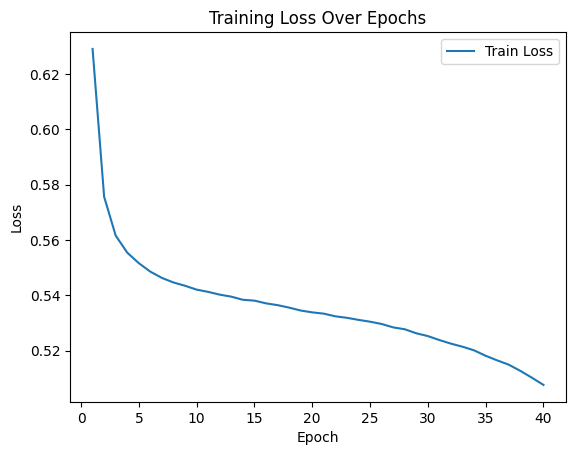

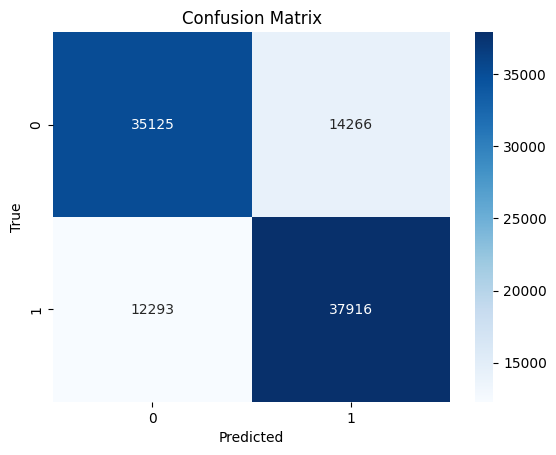

Accuracy: 73.33%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Dataset Class
class ParticleDataset(Dataset):
    def __init__(self, hdf5_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        for idx, file in enumerate(hdf5_files):
            with h5py.File(file, 'r') as f:
                X = f['X'][:]
                y = np.full((X.shape[0],), idx)  # Assign label 0 for electrons, 1 for photons
                self.data.append(X)
                self.labels.append(y)
        
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Load Dataset
full_dataset = ParticleDataset(['/kaggle/input/cms-particle-collison/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 
                                '/kaggle/input/cms-particle-collison/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'])

# Split into Train and Test  # **MODIFIED**
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Compute Mean and Std for Normalization on Train Set  # **MODIFIED**
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size
        images = images.view(batch_samples, -1)
        mean += images.mean(dim=1).sum().item()
        std += images.std(dim=1).sum().item()
        total_samples += batch_samples
    mean /= total_samples
    std /= total_samples
    return mean, std

mean, std = compute_mean_std(train_dataset)  # **MODIFIED**
print(f"Computed Mean: {mean}, Std: {std}")

# Define Data Augmentation and Normalization  # **MODIFIED**
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((mean,), (std,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Reload dataset with transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data Augmented")

# Define ResNet-like Model
# class ResNet15(nn.Module):
#     def __init__(self):
#         super(ResNet15, self).__init__()
#         self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.res_layers = self._make_res_layers(64, 128, 4)
#         # Compute final feature map size dynamically
#         with torch.no_grad():
#             dummy_input = torch.randn(1, 2, 32, 32)
#             dummy_output = self.res_layers(self.relu(self.bn1(self.conv1(dummy_input))))
#             final_h, final_w = dummy_output.shape[2], dummy_output.shape[3]
        
#         self.fc = nn.Linear(128 * final_h * final_w, 2)
    
#     def _make_res_layers(self, in_channels, out_channels, blocks):
#         layers = []
#         for _ in range(blocks):
#             layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
#             layers.append(nn.BatchNorm2d(out_channels))
#             layers.append(nn.ReLU(inplace=True))
#             in_channels = out_channels
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.res_layers(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.fc(x)
#         return x
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1  # Downsample only if specified
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Identity shortcut connection
        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet15, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual Blocks with Skip Connections
        self.layer1 = self._make_res_layers(64, 64, blocks=2, downsample=False)
        self.layer2 = self._make_res_layers(64, 128, blocks=2, downsample=True)
        self.layer3 = self._make_res_layers(128, 256, blocks=2, downsample=True)
        self.layer4 = self._make_res_layers(256, 512, blocks=2, downsample=True)

        # Compute final feature map size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, 2, 32, 32)  # Dummy input to infer shape
            dummy_output = self._forward_features(dummy_input)
            final_h, final_w = dummy_output.shape[2], dummy_output.shape[3]

        self.fc = nn.Linear(512 * final_h * final_w, num_classes)

    def _make_res_layers(self, in_channels, out_channels, blocks, downsample):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, downsample=False))
        return nn.Sequential(*layers)

    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet15().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# model.load_state_dict(torch.load("/kaggle/input/epoch30/pytorch/default/1/resnet15_weights.pth"))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
print("Model Created")

# Training Loop
num_epochs = 40
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

print("Training Finished")

# Plot Training Loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true):.2f}%')



torch.save(model.state_dict(), "resnet15_like_weights.pth")

In [3]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# import h5py
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.utils.data import Dataset, DataLoader, random_split

# # Custom Dataset Class
# class ParticleDataset(Dataset):
#     def __init__(self, hdf5_files, transform=None):
#         self.data = []
#         self.labels = []
#         self.transform = transform
        
#         for idx, file in enumerate(hdf5_files):
#             with h5py.File(file, 'r') as f:
#                 X = f['X'][:]
#                 y = np.full((X.shape[0],), idx)  # Assign label 0 for electrons, 1 for photons
#                 self.data.append(X)
#                 self.labels.append(y)
        
#         self.data = np.concatenate(self.data, axis=0)
#         self.labels = np.concatenate(self.labels, axis=0)
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         img = self.data[idx]
#         label = self.labels[idx]
        
#         if self.transform:
#             img = self.transform(img)
        
#         return img, label

# # Load Dataset
# full_dataset = ParticleDataset(['/kaggle/input/cms-particle-collison/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 
#                                 '/kaggle/input/cms-particle-collison/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'])

# # Split into Train and Test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# # Compute Mean and Std for Normalization on Train Set
# def compute_mean_std(dataset):
#     loader = DataLoader(dataset, batch_size=32, shuffle=False)
#     mean = 0.0
#     std = 0.0
#     total_samples = 0
#     for images, _ in loader:
#         batch_samples = images.size(0)  # Batch size
#         images = images.view(batch_samples, -1)
#         mean += images.mean(dim=1).sum().item()
#         std += images.std(dim=1).sum().item()
#         total_samples += batch_samples
#     mean /= total_samples
#     std /= total_samples
#     return mean, std

# mean, std = compute_mean_std(train_dataset)
# print(f"Computed Mean: {mean}, Std: {std}")

# # Define Data Augmentation and Normalization
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
#     transforms.Normalize((mean,), (std,))
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((mean,), (std,))
# ])

# # # Reload dataset with transforms
# train_dataset.dataset.transform = train_transform
# test_dataset.dataset.transform = test_transform

# # Data Loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# print("Data Augmented")

# # Define Improved ResNet-15 Model
# class ResNet15Enhanced(nn.Module):
#     def __init__(self):
#         super(ResNet15Enhanced, self).__init__()
#         self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.res_layers = self._make_res_layers(64, 128, 4)
#         self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(128, 2)
    
#     def _make_res_layers(self, in_channels, out_channels, blocks):
#         layers = []
#         for _ in range(blocks):
#             layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
#             layers.append(nn.BatchNorm2d(out_channels))
#             layers.append(nn.ReLU(inplace=True))
#             in_channels = out_channels
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.res_layers(x)
#         x = self.global_avg_pool(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x

# # Training Setup
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet15Enhanced().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# print("Model Created")

# # Training Loop
# num_epochs = 30
# train_losses = []
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()
#     epoch_loss = running_loss / len(train_loader)
#     train_losses.append(epoch_loss)
#     print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

# print("Training Finished")

# # Evaluation
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy: {100 * correct / total:.2f}%')

# torch.save(model.state_dict(), "resnet15_weights.pth")